<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/EffnetB3_Ben._proccess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

random.seed = 2
#np.random.seed = 2
tf.seed = 2


In [24]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_images_location+'/'+test_df['Image name']+'.jpg'
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] =  dataset_images_location+'/'+df['Image name']+'.jpg'
df_['Retinopathy grade'] = df['Retinopathy grade']#.astype('str')
print(df_.head())

df=pd.concat([df_,test_df])
df=df.sample(frac=1).reset_index()
print(df.shape)
test_df=df[-103:][['Image name','Retinopathy grade']]
train_df=df[0:-103][['Image name','Retinopathy grade']]
#train_df, val_df = train_test_split(df_, test_size = 0.1, random_state = 415);
#train_df.head()

                                          Image name  Retinopathy grade
0  /content/drive/My Drive/IDRid/B. Disease Gradi...                  3
1  /content/drive/My Drive/IDRid/B. Disease Gradi...                  3
2  /content/drive/My Drive/IDRid/B. Disease Gradi...                  2
3  /content/drive/My Drive/IDRid/B. Disease Gradi...                  3
4  /content/drive/My Drive/IDRid/B. Disease Gradi...                  4
(516, 3)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f879e2f0790>]],
      dtype=object)

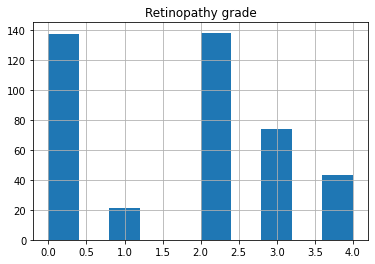

In [25]:
train_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87956d10d0>]],
      dtype=object)

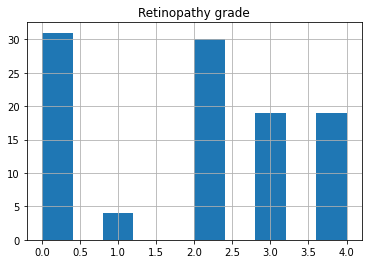

In [26]:
test_df.hist()

In [27]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 690 Old Size: 413


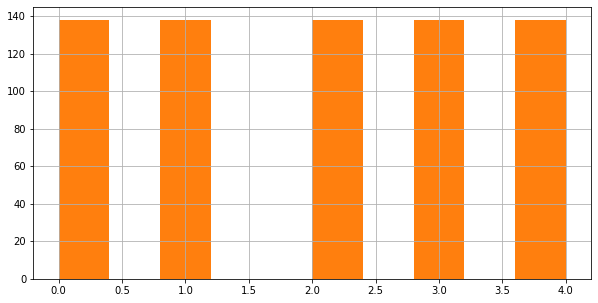

In [28]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [29]:
train_df['Retinopathy grade']=train_df['Retinopathy grade'].astype('str')
test_df['Retinopathy grade']=test_df['Retinopathy grade'].astype('str')

In [30]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    IMG_WIDTH=380
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_WIDTH))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

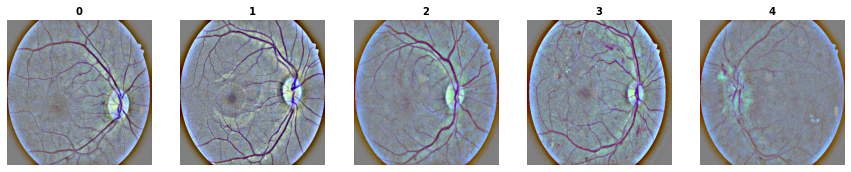

In [102]:
# Example of preprocessed images from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['Retinopathy grade'] == str(i)].sample(1)
    image_name = sample['Image name'].item()
    X = preprocess_image(imread((image_name)))
    ax[i].set_title((str(i)), weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [87]:
# We use a small batch size so we can handle large images easily
BATCH_SIZE = 4
IMG_WIDTH, IMG_HEIGHT=380,380

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.10,
                                   zoom_range=[0.75,1],
                                   width_shift_range=1.1,
                                   height_shift_range=0.05,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_image 
                                )

# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='Image name', 
                                                    y_col='Retinopathy grade',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                       
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='Image name', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  subset='validation')

Found 621 validated image filenames belonging to 5 classes.
Found 69 validated image filenames belonging to 5 classes.


In [88]:
from tensorflow.keras.applications import EfficientNetB3
import keras.backend as K
IMG_SIZE=380
def output_relu(x):
    return K.relu(x, max_value=4)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable=False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

In [89]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling_9 (Rescaling)         (None, 380, 380, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
normalization_9 (Normalization) (None, 380, 380, 3)  7           rescaling_9[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization_9[0][0]            
____________________________________________________________________________________________

In [90]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        min_delta=0.01)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.8), loss='categorical_crossentropy',metrics=['acc'])
model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[es,rlr]
                    )

Epoch 1/100
156/156 [==============================] - 128s 767ms/step - loss: 1.6908 - acc: 0.2097 - val_loss: 1.5449 - val_acc: 0.2319
Epoch 2/100
156/156 [==============================] - 117s 752ms/step - loss: 1.4910 - acc: 0.3324 - val_loss: 1.4435 - val_acc: 0.3768
Epoch 3/100
156/156 [==============================] - 117s 750ms/step - loss: 1.4039 - acc: 0.3978 - val_loss: 1.3573 - val_acc: 0.4058
Epoch 4/100
156/156 [==============================] - 116s 747ms/step - loss: 1.3604 - acc: 0.4033 - val_loss: 1.3163 - val_acc: 0.4493
Epoch 5/100
156/156 [==============================] - 117s 749ms/step - loss: 1.2472 - acc: 0.4697 - val_loss: 1.3244 - val_acc: 0.4058
Epoch 6/100
156/156 [==============================] - 117s 748ms/step - loss: 1.2242 - acc: 0.4729 - val_loss: 1.3256 - val_acc: 0.4203
Epoch 7/100
156/156 [==============================] - 118s 756ms/step - loss: 1.2226 - acc: 0.4836 - val_loss: 1.2844 - val_acc: 0.4493
Epoch 8/100
156/156 [====================

[[ 3  4  0  0  2]
 [ 1  9  0  0  0]
 [ 1  4  9  2  3]
 [ 1  0  2  8  3]
 [ 0  0  0  4 12]]
0.6029411764705882  accuracy


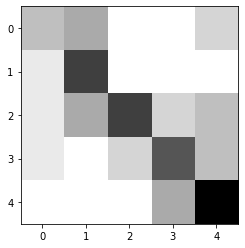

In [91]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_=np.zeros((len(val_generator)*4-4,5))
val_labels=np.zeros((len(val_generator)*4-4,5)) 

for i,(img,lbl) in enumerate(val_generator):
  if i==len(val_generator)-1:
    break
  pred_y_[4*i:4*i+4]=model.predict(img)
  val_labels[4*i:i*4+4]=lbl

cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))," accuracy")


In [92]:
# Add Image augmentation to our generator
test_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.10,
                                   zoom_range=[0.75,1],
                                   width_shift_range=1.1,
                                   height_shift_range=0.05,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_image 
                                )

# Use the dataframe to define train and validation generators
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                    x_col='Image name', 
                                                    y_col='Retinopathy grade',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE)

Found 103 validated image filenames belonging to 5 classes.


[[21  6  3  0  1]
 [ 1  2  0  0  0]
 [ 3  4  9  8  5]
 [ 0  2  4  6  7]
 [ 1  0  2  6  9]]
0.47  accuracy


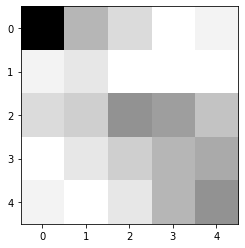

In [93]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_1=np.zeros((len(test_generator)*4-4,5))
test_labels=np.zeros((len(test_generator)*4-4,5)) 

for i,(img,lbl) in enumerate(test_generator):
  if i==len(test_generator)-1:
    break
  pred_y_1[4*i:4*i+4]=model.predict(img)
  test_labels[4*i:i*4+4]=lbl

cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_1,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_1,axis=1))," accuracy")


## unfreezwze and train

In [94]:
model.trainable=True
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
print("Trainable weights ",trainable_count)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        min_delta=0.01)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5,beta_1=0.8), loss='categorical_crossentropy',metrics=['acc'])
model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=100,
                    validation_data=val_generator,
                    callbacks=[es,rlr]
                    )

Trainable weights  10703917
Epoch 1/100
156/156 [==============================] - 146s 850ms/step - loss: 1.4718 - acc: 0.2940 - val_loss: 1.3713 - val_acc: 0.4348
Epoch 2/100
156/156 [==============================] - 130s 829ms/step - loss: 1.3601 - acc: 0.3985 - val_loss: 1.3387 - val_acc: 0.4348
Epoch 3/100
156/156 [==============================] - 129s 829ms/step - loss: 1.2204 - acc: 0.4997 - val_loss: 1.2811 - val_acc: 0.4638
Epoch 4/100
156/156 [==============================] - 129s 827ms/step - loss: 1.2381 - acc: 0.4548 - val_loss: 1.1978 - val_acc: 0.4928
Epoch 5/100
156/156 [==============================] - 129s 826ms/step - loss: 1.1983 - acc: 0.5235 - val_loss: 1.1652 - val_acc: 0.6087
Epoch 6/100
156/156 [==============================] - 129s 825ms/step - loss: 1.1632 - acc: 0.5004 - val_loss: 1.1056 - val_acc: 0.5507
Epoch 7/100
156/156 [==============================] - 129s 826ms/step - loss: 1.0788 - acc: 0.5887 - val_loss: 1.1029 - val_acc: 0.6087
Epoch 8/100
1

KeyboardInterrupt: ignored

[[29  0  1  0  0]
 [ 4  0  0  0  0]
 [ 4  1 16  4  4]
 [ 1  0  6  5  6]
 [ 1  0  3  4 11]]
0.61  accuracy


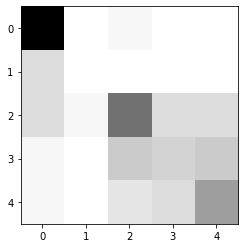

In [99]:
pred_y_2=np.zeros((len(test_generator)*4-4,5))
test_labels_2=np.zeros((len(test_generator)*4-4,5)) 

for i,(img,lbl) in enumerate(test_generator):
  if i==len(test_generator)-1:
    break
  pred_y_2[4*i:4*i+4]=model.predict(img)
  test_labels_2[4*i:i*4+4]=lbl

cm=confusion_matrix(np.argmax(test_labels_2,axis=1),np.argmax(pred_y_2,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(test_labels_2,axis=1),np.argmax(pred_y_2,axis=1))," accuracy")

##progressive resize

In [111]:
base_model_ = EfficientNetB3(weights=None, include_top=False, input_shape=(IMG_SIZE*2,IMG_SIZE*2,3))
base_model_.trainable=False
x = base_model_.output
x = layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(5, activation='softmax')(x)
model_resize = Model(inputs=base_model_.input, outputs=x)
model_resize.set_weights(model.get_weights()) 

In [112]:
# We use a small batch size so we can handle large images easily
BATCH_SIZE = 4
IMG_WIDTH, IMG_HEIGHT=380,380

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.10,
                                   zoom_range=[0.75,1],
                                   width_shift_range=1.1,
                                   height_shift_range=0.05,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_image 
                                )
# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='Image name', 
                                                    y_col='Retinopathy grade',
                                                    target_size=(IMG_WIDTH*2, IMG_HEIGHT*2),
                                                    batch_size=BATCH_SIZE,
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='Image name', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  subset='validation')

In [106]:
"""def predict(X, coef=[0.5, 1.5, 2.5, 3.5]):
    X_p = np.copy(X)
    for i, pred in enumerate(X_p):
        if pred < coef[0]:
            X_p[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            X_p[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            X_p[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            X_p[i] = 3
        else:
            X_p[i] = 4
    return X_p
"""

'def predict(X, coef=[0.5, 1.5, 2.5, 3.5]):\n    X_p = np.copy(X)\n    for i, pred in enumerate(X_p):\n        if pred < coef[0]:\n            X_p[i] = 0\n        elif pred >= coef[0] and pred < coef[1]:\n            X_p[i] = 1\n        elif pred >= coef[1] and pred < coef[2]:\n            X_p[i] = 2\n        elif pred >= coef[2] and pred < coef[3]:\n            X_p[i] = 3\n        else:\n            X_p[i] = 4\n    return X_p\n'

In [107]:
"""pred_lbls=np.zeros((len(train_generator)*4-4,1))
act_lbls =np.zeros((len(train_generator)*4-4,1))
for i,(img,lbl) in enumerate(train_generator):
  #print(i)
  if i==len(train_generator)-1:
    break
  pred_lbls[4*i:i*4+4]=predict(model.predict(img))
  act_lbls[4*i:i*4+4]=np.expand_dims(lbl,axis=1)"""

'pred_lbls=np.zeros((len(train_generator)*4-4,1))\nact_lbls =np.zeros((len(train_generator)*4-4,1))\nfor i,(img,lbl) in enumerate(train_generator):\n  #print(i)\n  if i==len(train_generator)-1:\n    break\n  pred_lbls[4*i:i*4+4]=predict(model.predict(img))\n  act_lbls[4*i:i*4+4]=np.expand_dims(lbl,axis=1)'

In [108]:
"""from sklearn.metrics import precision_score,accuracy_score
accuracy_score(act_lbls,pred_lbls)"""

'from sklearn.metrics import precision_score,accuracy_score\naccuracy_score(act_lbls,pred_lbls)'

In [109]:
"""cm=confusion_matrix(act_lbls,pred_lbls)"""

'cm=confusion_matrix(act_lbls,pred_lbls)'

In [110]:
"""print(cm)
plt.imshow(cm, cmap='binary')"""

"print(cm)\nplt.imshow(cm, cmap='binary')"